# Book Recommendation System using Collaborative Filtering with clustering.


## Collaborative Filtering

Collaborative Filtering (CF) is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences from many users (collaborating).

**The underlying assumption is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue than that of a random person.**

CF can be divided into two main categories:

1. **User-based Collaborative Filtering**: Recommendations are made based on the preferences of similar users. For instance, if user X likes books A and B, and user Y likes book A, book B can be recommended to Y.

2. **Item-based Collaborative Filtering**: This approach focuses on the similarity between items. For instance, if users typically buy items A and B together, then a user buying item A might be recommended item B.

### Clustering Approach in Collaborative Filtering

The clustering approach in CF involves grouping similar items (item-based) or users (user-based) into clusters before making recommendations.

1. **User Clustering**: Here, users are grouped based on their preferences and profiles. Users within the same cluster are considered to have similar tastes. When recommending an item, the system looks at the preference of the cluster to which the active user belongs.

2. **Item Clustering**: This involves grouping similar items together. For a user, the system recommends items that are in the same cluster as the items the user has positively interacted with in the past.

### Combining Clustering with Collaborative Filtering

By combining clustering with collaborative filtering, the recommendation system becomes more efficient and scalable. Here's how it works:

- **Pre-processing with Clustering**: Initially, clustering is used to group similar users or items, reducing the complexity of the data. This step helps in managing large datasets by focusing on a subset of relevant users or items in the same cluster.

- **Applying Collaborative Filtering on Clusters**: Once clusters are formed, collaborative filtering is applied within these clusters to make recommendations. This approach narrows down the computation to a more manageable size and often improves the accuracy of the recommendations, as the comparisons are made within more homogenous groups.

### Benefits

- **Scalability**: Handling large datasets is more feasible as clustering reduces the size of the comparison pool.
- **Accuracy**: Recommendations are often more accurate as they are based on more homogenized and relevant groups.
- **Speed**: Reduces computational complexity, making the recommendation process faster.

### Challenges

- **Determining the Number of Clusters**: Choosing the right number of clusters can be challenging and might require several iterations.



## Notebook Roadmap and Rationale

- **Goal**: Build an item-based book recommender that leverages collaborative filtering, explores clustering structure, and returns similar titles for a given book.
- **Data ingestion & cleanup**: Load books, users, and ratings CSVs with Latin-1 decoding; drop low-value columns (e.g., publication year, duplicate image URLs), and rename fields for readability so downstream merges/pivots stay clear.
- **EDA to sanity-check**: Plot author/publisher/book frequencies plus user age/location and rating distributions to spot sparsity, skew, or obvious data quality issues before modeling.
- **Filtering to reduce noise**: Keep only users with >200 ratings and books with >=50 interactions, then deduplicate by title/user to focus on reliable signals instead of one-off ratings.
- **Matrix prep**: Create a title-by-user pivot of rating counts, fill missing entries with 0, and convert to a sparse matrix so vector-based models stay memory efficient.
- **Clustering exploration**: Run KMeans across k=1..10 and plot an elbow curve to gauge whether meaningful clusters exist before committing to a cluster-aware recommender.
- **Nearest-neighbor recommender**: Fit a brute-force `NearestNeighbors` model on the sparse matrix; given a title, fetch its closest neighbors and print similar books (excluding the query itself).
- **Persist artifacts & helper**: Save the fitted model, book index, ratings slice, and pivot to `artifacts/` for reuse; expose `recommend_book` for quick manual checks and downstream integration.



# 1. Import Necessary Libraries

In [145]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. EDA

In [146]:
# Loading book data from a CSV file
books_df = pd.read_csv('../Data/books.csv', sep=';',
                       on_bad_lines='skip',
                       encoding='latin-1',
                       low_memory=False)


In [147]:
# Displaying the first few rows of the books data
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [148]:
# Checking the shape of the books data
books_df.shape

(271360, 8)

In [149]:
# Displaying the columns in the books data
books_df.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

The columns description of the books_df are as followings:

`ISBN`:- ISBN number of the book

`Book-Title`:- title of the book

`Book-Author`:- author of the book

`Year-Of-Publication`:-  year of publication

`Publisher`:- publisher of the book

`Image-URL-S`:- url

`Image-URL-M`:- url

`Image-URL-L`:- url

Based on the above description and our choosen collaborative filtering techniques, we can take the following actions:

- Column `Year-Of-Publication` does not provide any significant information for the collaborative filtering techniques so we can drop it.
- Columns `Image-URL-S`, `Image-URL-M`, and `Image-URL-L`provides the same information so we can drop `Image-URL-S` and `Image-URL-M`.
- we can rename other columns for ease of use.

In [150]:
# Dropping the above suggested columns
books_df.drop(['Year-Of-Publication', 'Image-URL-S', 'Image-URL-M'],
              axis = 1, inplace=True)

In [151]:
# Renaming columns for better readability and consistency
books_df.rename(columns={
    'Book-Title': 'title',
    'Book-Author': 'author',
    'Publisher': 'publisher',
    'Image-URL-L': 'url'
}, inplace=True)

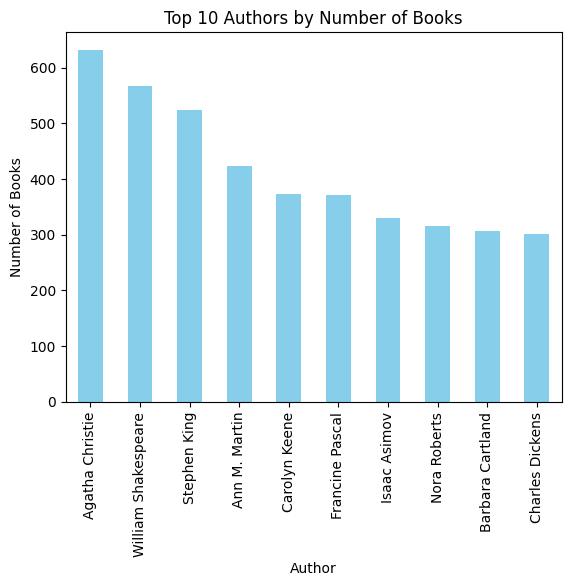

In [152]:
# visualise top 10 authors
top_authors = books_df['author'].value_counts().head(10)
top_authors.plot(kind='bar', color='skyblue', title='Top 10 Authors by Number of Books')
plt.xlabel('Author')
plt.ylabel('Number of Books')
plt.show()


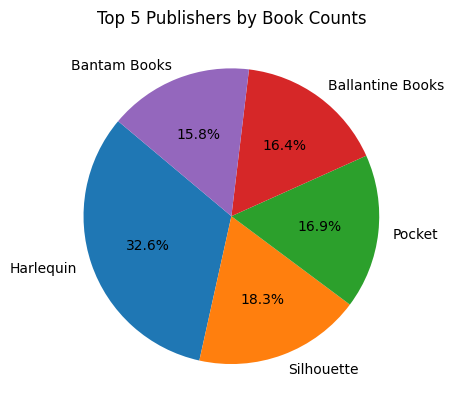

In [153]:
# top 5 publishers by book counts
top_publishers = books_df['publisher'].value_counts().head(5)
top_publishers.plot(kind='pie', autopct='%1.1f%%', startangle=140, title='Top 5 Publishers by Book Counts')
plt.ylabel('')
plt.show()


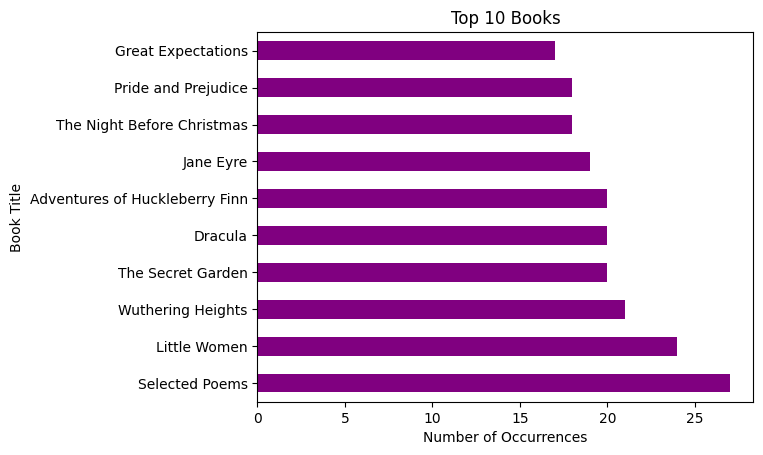

In [154]:
top_books = books_df['title'].value_counts().head(10)
top_books.plot(kind='barh', color='purple', title='Top 10 Books')
plt.xlabel('Number of Occurrences')
plt.ylabel('Book Title')
plt.show()


In [155]:
# Loading user data from a CSV file
users_df = pd.read_csv('../Data/users.csv', sep=';',
                       on_bad_lines='skip',
                       encoding='latin-1',
                       low_memory=False)


In [156]:
# Checking the shape of the users data
users_df.shape

(278858, 3)

In [157]:
# Displaying the first few rows of the users data
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


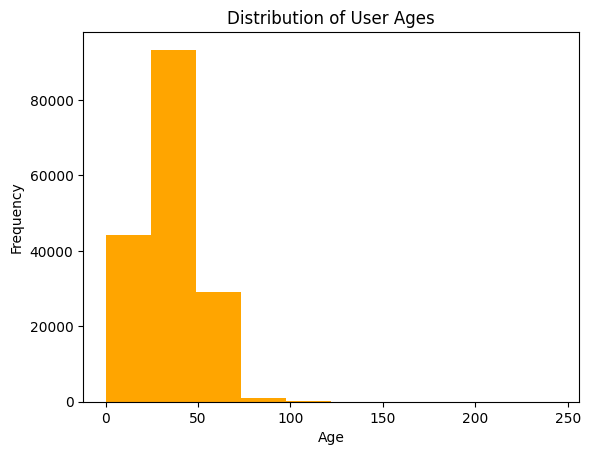

In [158]:
# Plotting the Distribution of User Ages
users_df['Age'].plot(kind='hist', bins=10,
                     color='orange', title='Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

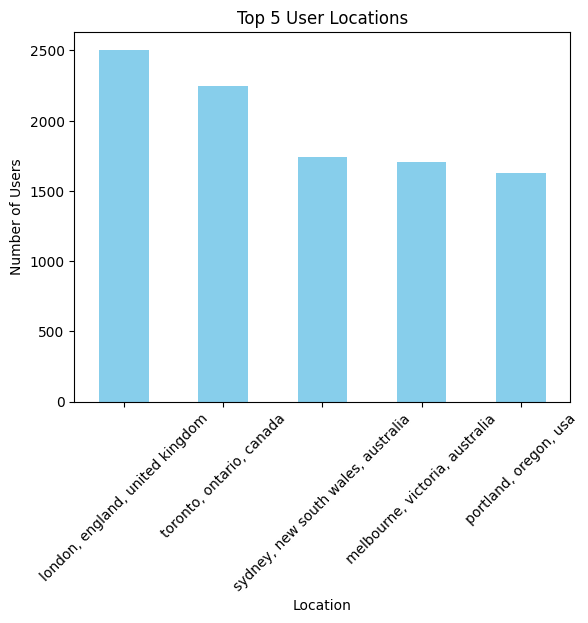

In [159]:
# Plotting the Top 5 User Locations
top_locations = users_df['Location'].value_counts().head(5)
top_locations.plot(kind='bar', color='skyblue',
                   title='Top 5 User Locations')
plt.xlabel('Location')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()


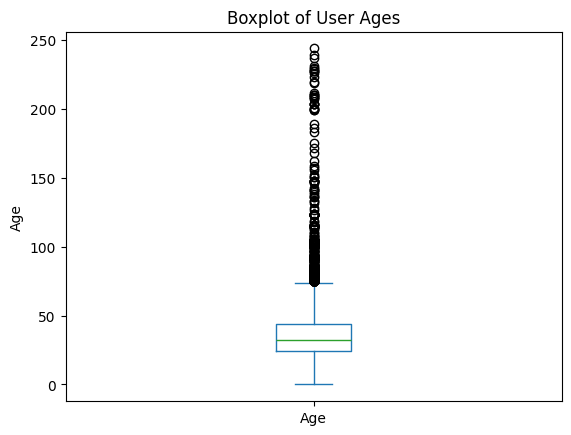

In [160]:
# Plotting the Boxplot of User Ages
users_df['Age'].plot(kind='box', title='Boxplot of User Ages')
plt.ylabel('Age')
plt.show()


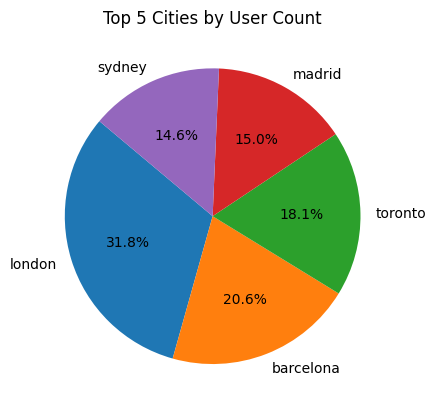

In [161]:
# Plotting the Top 5 Cities by User Count
top_cities = users_df['Location'].apply(lambda x: x.split(',')[0]).value_counts().head(5)
top_cities.plot(kind='pie', autopct='%1.1f%%', startangle=140,
                title='Top 5 Cities by User Count')
plt.ylabel('')
plt.show()


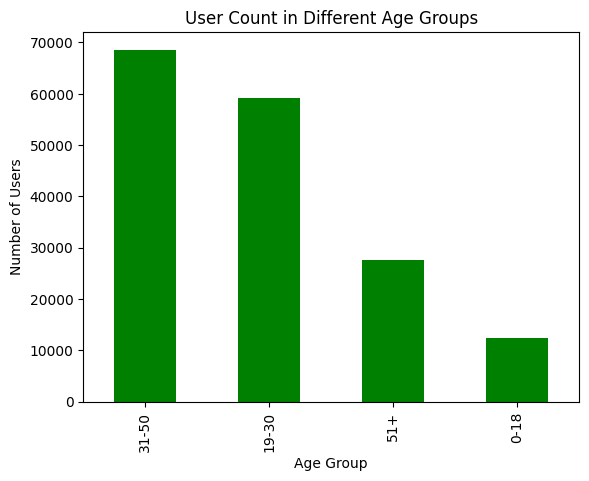

In [162]:
# Plotting the User Count in Different Age Groups
bins = [0, 18, 30, 50, 100]
labels = ['0-18', '19-30', '31-50', '51+']
users_df['AgeGroup'] = pd.cut(users_df['Age'], bins=bins, labels=labels, right=False)
age_group_counts = users_df['AgeGroup'].value_counts()
age_group_counts.plot(kind='bar', color='green',
                      title='User Count in Different Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Number of Users')
plt.show()


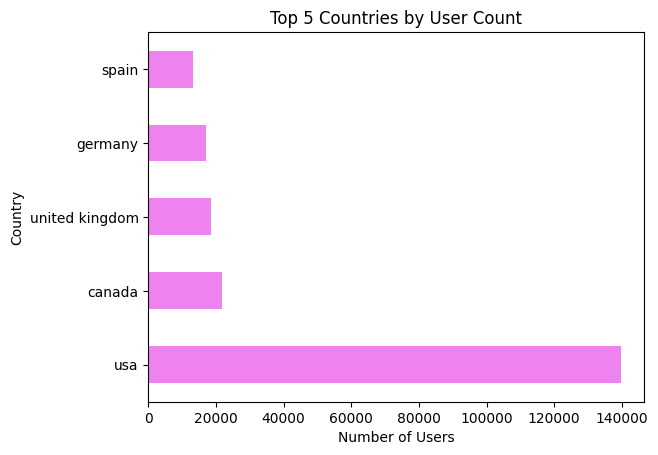

In [163]:
# Plotting the Top 5 Countries by User Count
top_countries = users_df['Location'].apply(lambda x: x.split(',')[-1].strip()).value_counts().head(5)
top_countries.plot(kind='barh', color='violet',
                   title='Top 5 Countries by User Count')
plt.xlabel('Number of Users')
plt.ylabel('Country')
plt.show()


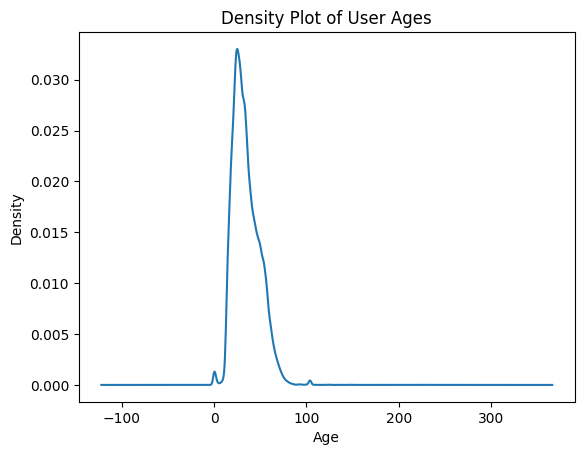

In [164]:
# Plotting the Density Plot of User Ages
users_df['Age'].plot(kind='density',
                     title='Density Plot of User Ages')
plt.xlabel('Age')
plt.show()


In [165]:
# Loading rating data from a CSV file
ratings_df = pd.read_csv('../Data/ratings.csv', sep=';',
                       on_bad_lines='skip',
                       encoding='latin-1',
                       low_memory=False)


In [166]:
# Checking the shape of the ratings data
ratings_df.shape

(1149780, 3)

In [167]:
# Renaming columns in the ratings data for consistency
ratings_df.rename(columns={
    'User-ID': 'user_id',
    'Book-Rating': 'rating'
    }, inplace=True)

In [168]:
# Displaying the first few rows of the ratings data
ratings_df.head()

,user_id,ISBN,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


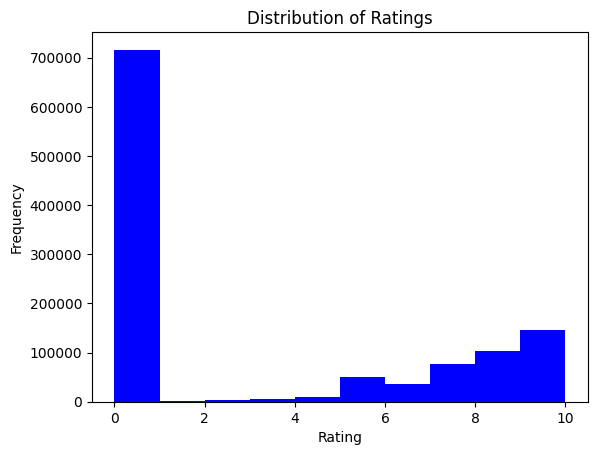

In [169]:
# Plotting the Distribution of Ratings
ratings_df['rating'].plot(kind='hist', bins=10, color='blue',
                          title='Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

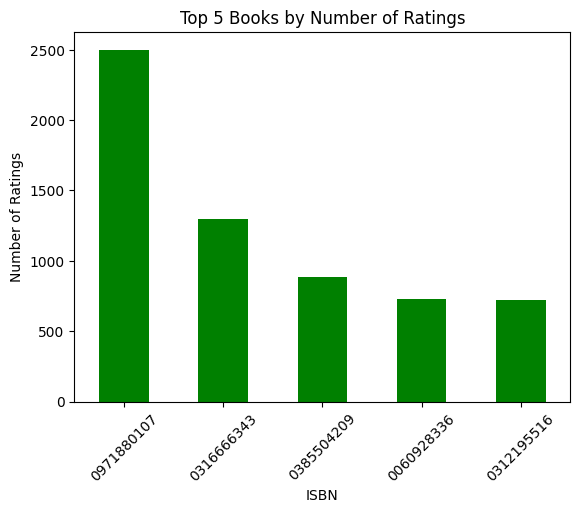

In [170]:
# Plotting the Top 5 Books by Number of Ratings
top_books = ratings_df['ISBN'].value_counts().head(5)
top_books.plot(kind='bar', color='green',
               title='Top 5 Books by Number of Ratings')
plt.xlabel('ISBN')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()


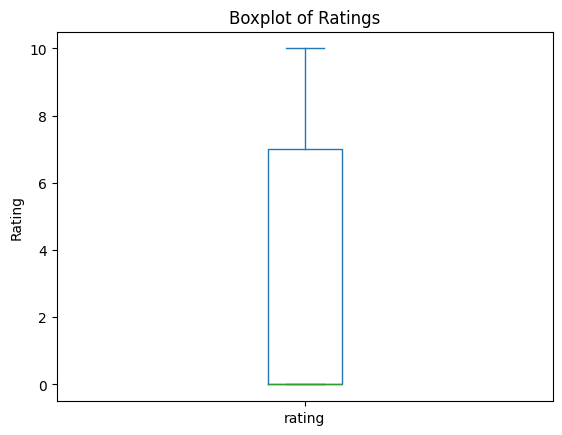

In [171]:
# Plotting the Boxplot of Ratings
ratings_df['rating'].plot(kind='box', title='Boxplot of Ratings')
plt.ylabel('Rating')
plt.show()


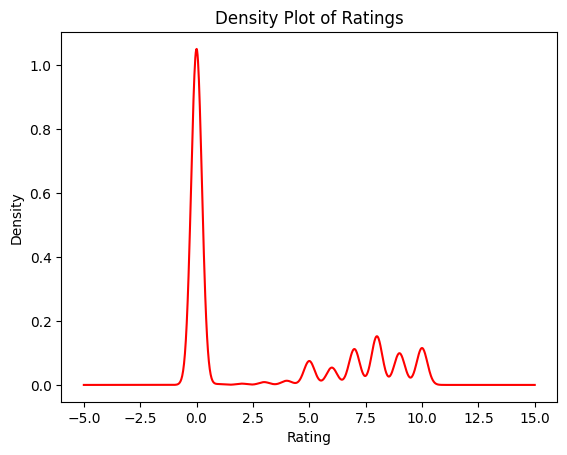

In [172]:
# Plotting the Density Plot of Ratings
ratings_df['rating'].plot(kind='density', color='red',
                          title='Density Plot of Ratings')
plt.xlabel('Rating')
plt.show()


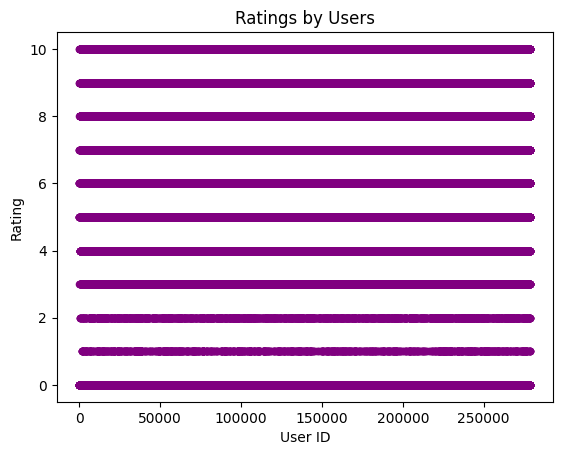

In [173]:
# Plotting the Ratings by Users
ratings_df.plot(kind='scatter', x='user_id', y='rating',
                color='purple', title='Ratings by Users')
plt.xlabel('User ID')
plt.ylabel('Rating')
plt.show()


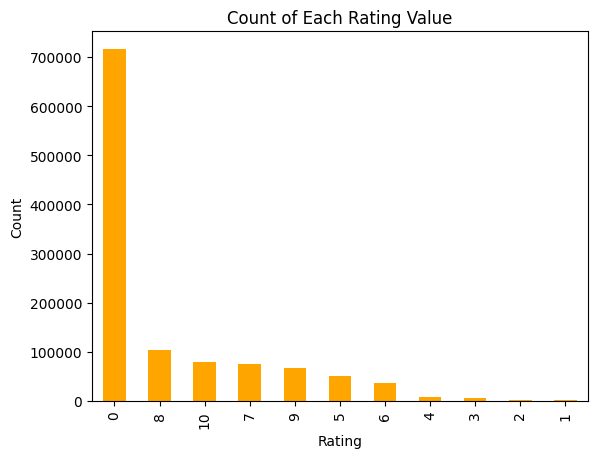

In [174]:
# Plotting the Count of Each Rating Value
ratings_df['rating'].value_counts().plot(kind='bar',
                                         color='orange',
                                         title='Count of Each Rating Value')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


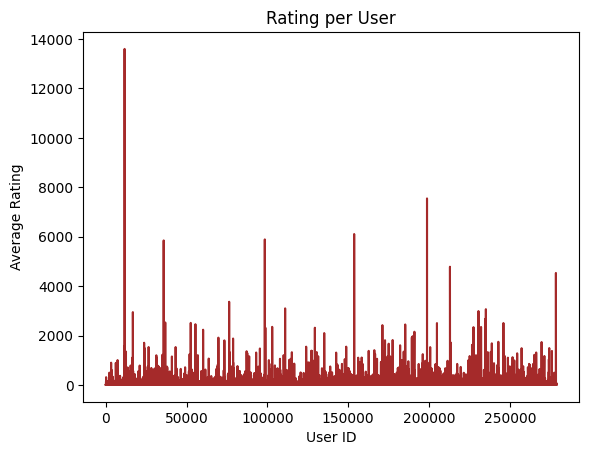

In [175]:
# Plotting the Rating per User
ratings_df.groupby('user_id')['rating'].count().plot(kind='line',
                                                    color='brown',
                                                    title='Rating per User')
plt.xlabel('User ID')
plt.ylabel('Average Rating')
plt.show()



## EDA Findings Snapshot

- Top authors by title count: Agatha Christie (632), William Shakespeare (567), Stephen King (524), Ann M. Martin (423), Carolyn Keene (373).
- Top publishers: Harlequin (7,535), Silhouette (4,220), Pocket (3,905), Ballantine Books (3,783), Bantam Books (3,646) dominate the catalog.
- Most duplicated titles: Selected Poems (27 editions), Little Women (24), Wuthering Heights (21), The Secret Garden (20), Dracula (20), indicating many reprints.
- User ages: median 32, mean 34.8 with a long tail (0 to 244) and 75% under 44; outliers exist but core users sit in the 19-50 range.
- Top locations: London, England, UK (2,506); Toronto, Ontario, Canada (2,250); Sydney, New South Wales, Australia (1,744); Melbourne, Victoria, Australia (1,708); Portland, Oregon, USA (1,629).
- Top cities overall: London (4,105), Barcelona (2,664), Toronto (2,342), Madrid (1,933), Sydney (1,884).
- Country mix: USA (139,711), Canada (21,658), United Kingdom (18,538), Germany (17,043), Spain (13,147) cover most users.
- Age group split: 31-50 (68,589), 19-30 (59,192), 51+ (27,632), 0-18 (12,310); few minors, strong adult base.
- Ratings distribution: heavily zero-inflated (716,109 of 1.15M ratings are 0), mean 2.87, 75th percentile 7, max 10; non-zero peaks around 8-10.
- Top books by rating count: ISBN 0971880107 (2,502 ratings), 0316666343 (1,295), 0385504209 (883), 0060928336 (732), 0312195516 (723) provide the densest signals.
- Rating value counts: 0 dominates, then 8 (103,736), 10 (78,610), 7 (76,457), 9 (67,541); tail tapers for 1-6.
- User-by-rating scatter/line plots show sparsity: most users give few ratings, with a smaller highly active core (later filtered with the >200 rule).



# 3. Data Preprocessing

In [176]:
# Filtering out users who have given less than 200 ratings
active_users_filter = ratings_df['user_id'].value_counts() > 200
active_users = active_users_filter[active_users_filter].index
ratings_df = ratings_df[ratings_df['user_id'].isin(active_users)]

In [177]:
# Displaying the first few rows of the filtered ratings data
ratings_df.head()

,user_id,ISBN,rating
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0


In [178]:
# Merging the ratings data with books data
merged_ratings_books_df = ratings_df.merge(books_df, on='ISBN')

In [179]:
# Displaying the first two rows of the merged data
merged_ratings_books_df.head(2)

,user_id,ISBN,rating,title,author,publisher,url
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,Lucy Moll,John Wiley &amp; Sons,http://images.amazon.com/images/P/0026217457.0...


In [180]:
# Checking the shape of the merged data
merged_ratings_books_df.shape

(487671, 7)

In [181]:
# Grouping the merged data by book title and counting the ratings
book_rating_counts = merged_ratings_books_df.groupby('title').rating.count().reset_index()


In [182]:
# Displaying the first few rows of the rating counts
book_rating_counts.head()

,title,rating
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


In [183]:
# Merging the rating counts with the merged ratings and books data
final_ratings_df = merged_ratings_books_df.merge(book_rating_counts, on='title')


In [184]:
# Displaying the first two rows of the final ratings data
final_ratings_df.head(2)

,user_id,ISBN,rating_x,title,author,publisher,url,rating_y
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
1,277427,0026217457,0,Vegetarian Times Complete Cookbook,Lucy Moll,John Wiley &amp; Sons,http://images.amazon.com/images/P/0026217457.0...,7


In [185]:
# Checking the shape
final_ratings_df.shape

(487671, 8)

In [186]:
# Filtering the final ratings data to include books with at least 50 ratings
final_ratings_df = final_ratings_df[final_ratings_df['rating_y'] >= 50]

In [187]:
# Displaying the first three rows of the filtered final ratings data
final_ratings_df.head(3)

,user_id,ISBN,rating_x,title,author,publisher,url,rating_y
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner,John Wiley &amp; Sons Inc,http://images.amazon.com/images/P/002542730X.0...,82
13,277427,0060930535,0,The Poisonwood Bible: A Novel,Barbara Kingsolver,Perennial,http://images.amazon.com/images/P/0060930535.0...,133
15,277427,0060934417,0,Bel Canto: A Novel,Ann Patchett,Perennial,http://images.amazon.com/images/P/0060934417.0...,108


In [188]:
# Checking the shape
final_ratings_df.shape

(61853, 8)

In [189]:
# Dropping duplicate entries based on title and user_id
final_ratings_df.drop_duplicates(['title', 'user_id'], inplace=True)

In [190]:
# Creating a pivot table for the user-book matrix
user_book_matrix = final_ratings_df.pivot_table(columns='user_id', index='title', values='rating_y')


In [191]:
user_book_matrix

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,76.0,NaN,NaN,NaN,NaN
1st to Die: A Novel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Chance,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,124.0,NaN,NaN,NaN,NaN,124.0,NaN
4 Blondes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84 Charing Cross Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,54.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,NaN,NaN,NaN,59.0,NaN,NaN,NaN,NaN,59.0,NaN,...,NaN,NaN,NaN,NaN,NaN,59.0,NaN,NaN,NaN,NaN
You Belong To Me,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,NaN,NaN,NaN,NaN,64.0,NaN,NaN,NaN,NaN,64.0,...,NaN,NaN,NaN,NaN,NaN,64.0,NaN,NaN,NaN,NaN


In [192]:
# Filling missing values in the pivot table with 0
user_book_matrix.fillna(0, inplace=True)

In [193]:
user_book_matrix

user_id,254,2276,2766,2977,3363,3757,4017,4385,6242,6251,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,76.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,76.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,124.0,0.0,0.0,0.0,0.0,124.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Year of Wonders,0.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0,59.0,0.0,...,0.0,0.0,0.0,0.0,0.0,59.0,0.0,0.0,0.0,0.0
You Belong To Me,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0,64.0,...,0.0,0.0,0.0,0.0,0.0,64.0,0.0,0.0,0.0,0.0


In [194]:
# Importing the csr_matrix function from scipy.sparse
from scipy.sparse import csr_matrix

In [195]:
# Creating a sparse matrix from the user-book matrix
sparse_user_book_matrix = csr_matrix(user_book_matrix)

# 4. Modelling

In [196]:
from sklearn.cluster import KMeans

In [197]:
# List to store the sum of squared distances for each k
sum_of_squared_distances = []

In [198]:
# Trying different numbers of clusters
for k in range(1, 11):
    km = KMeans(n_clusters=k)
    km = km.fit(sparse_user_book_matrix)
    sum_of_squared_distances.append(km.inertia_)

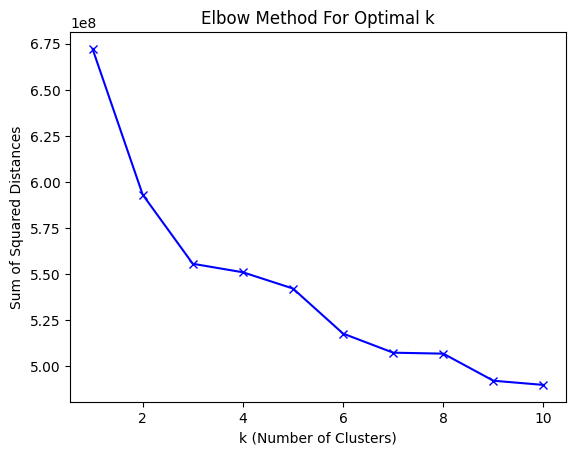

In [199]:
# Plotting the elbow graph
plt.plot(range(1, 11), sum_of_squared_distances, 'bx-')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [200]:
from sklearn.neighbors import NearestNeighbors

In [201]:
# Initializing the NearestNeighbors model with 'brute' algorithm
nearest_neighbors_model = NearestNeighbors(algorithm='brute')

In [202]:
# Fitting the model to the sparse user-book matrix
nearest_neighbors_model.fit(sparse_user_book_matrix)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"radius radius: float, default=1.0Range of parameter space to use by default for :meth:`radius_neighbors`queries.",1.0
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'brute'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"p p: float (positive), default=2Parameter for the Minkowski metric fromsklearn.metrics.pairwise.pairwise_distances. When p = 1, this isequivalent to using manhattan_distance (l1), and euclidean_distance(l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used.",2
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [203]:
# Finding the nearest neighbors for a specific book
distances, suggestions = nearest_neighbors_model.kneighbors(
    user_book_matrix.iloc[237, :].values.reshape(1, -1), n_neighbors=6)

In [204]:
# Displaying the distances
distances

array([[   0.        , 1753.17340842, 1822.42201479, 2082.78227379,
        2190.89776119, 2211.19741317]])

In [205]:
# Extracting book titles from the user-book matrix
book_titles = user_book_matrix.index

In [206]:
# Displaying the book titiles
book_titles

Index(['1984', '1st to Die: A Novel', '2nd Chance', '4 Blondes',
       '84 Charing Cross Road', 'A Bend in the Road', 'A Case of Need',
       'A Child Called \It\": One Child's Courage to Survive"',
       'A Civil Action', 'A Cry In The Night',
       ...
       'Winter Solstice', 'Wish You Well', 'Without Remorse',
       'Wizard and Glass (The Dark Tower, Book 4)', 'Wuthering Heights',
       'Year of Wonders', 'You Belong To Me',
       'Zen and the Art of Motorcycle Maintenance: An Inquiry into Values',
       'Zoya', '\O\" Is for Outlaw"'],
      dtype='object', name='title', length=742)

# 5. Save the Artifacts

In [207]:
# Importing the pickle module for model serialization
import pickle

# Saving the model and related data structures using Pickle
pickle.dump(nearest_neighbors_model, open('../artifacts/model.pkl', 'wb'))
pickle.dump(book_titles, open('../artifacts/books_name.pkl', 'wb'))
pickle.dump(final_ratings_df, open('../artifacts/ratings.pkl', 'wb'))
pickle.dump(user_book_matrix, open('../artifacts/book_pivot.pkl', 'wb'))

# 6. Recommendation Pipeline

In [208]:
# Defining a function to recommend books based on a given book title
def recommend_book(target_book):
    try:
        # Finding the index of the target book in the matrix
        book_id = np.where(user_book_matrix.index == target_book)[0][0]

        # Finding the nearest neighbors of the target book
        distances, suggestions = nearest_neighbors_model.kneighbors(
            sparse_user_book_matrix[book_id].reshape(1, -1), n_neighbors=6)

        # Printing the titles of the recommended books, excluding the target book
        for i in range(len(suggestions)):
            for j in suggestions[i]:
                suggested_book = user_book_matrix.index[j]
                if suggested_book != target_book: # Check to exclude the target book
                    print(suggested_book)
    except IndexError:
        # Handling the case where the book is not found in the matrix
        print(f"No recommendations found for '{target_book}'.")


In [209]:
# Example usage of the recommend_book function
recommend_book('A Bend in the Road')

Nights in Rodanthe
The Pull of the Moon
The Boy Next Door
The Guardian
Night Whispers



# 7. Evaluation (RMSE, MAE, Precision@K, Recall@K)

We evaluate the item-based recommender on a held-out set of user ratings. The steps:
- Split interactions per user into train/test (stratified by user).
- Train a cosine-similarity `NearestNeighbors` model on the train pivot (ratings matrix).
- Predict held-out ratings via neighbor-weighted average for RMSE/MAE.
- Build per-user top-K recommendations from their train items and compute Precision@K/Recall@K for relevant (rating ≥ 7) items.


In [210]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

# Use the already prepared ratings dataframe with actual ratings (rating_x)
ratings_eval = final_ratings_df[['user_id', 'title', 'rating_x', 'rating_y']].copy()
ratings_eval.rename(columns={'rating_x': 'rating', 'rating_y': 'rating_count'}, inplace=True)

# Keep only users and titles that survived previous filtering
print(f'Total interactions for eval: {len(ratings_eval)}')


Total interactions for eval: 59850


In [211]:
# Per-user train/test split
def train_test_split_by_user(df, test_frac=0.2, random_state=42):
    train_parts = []
    test_parts = []
    rng = np.random.default_rng(random_state)
    for user_id, grp in df.groupby('user_id'):
        n = len(grp)
        if n == 1:
            train_parts.append(grp)
            continue
        n_test = max(1, int(np.floor(test_frac * n)))
        test_idx = rng.choice(grp.index, size=n_test, replace=False)
        test_parts.append(grp.loc[test_idx])
        train_parts.append(grp.drop(test_idx))
    return pd.concat(train_parts), pd.concat(test_parts)

train_df, test_df = train_test_split_by_user(ratings_eval, test_frac=0.2, random_state=42)
print(f'Train interactions: {len(train_df)}, Test interactions: {len(test_df)}')


Train interactions: 48206, Test interactions: 11644


In [212]:
# Build item-user pivot on train set
pivot_train = train_df.pivot_table(index='title', columns='user_id', values='rating', fill_value=0)
print(f'Pivot shape (items x users): {pivot_train.shape}')

# Fit item-based nearest neighbors on train pivot
item_knn = NearestNeighbors(metric='cosine', algorithm='brute')
item_knn.fit(pivot_train)

# Precompute user means for cold predictions
user_means = train_df.groupby('user_id')['rating'].mean()
global_mean = train_df['rating'].mean()


Pivot shape (items x users): (742, 888)


In [213]:
def predict_rating(user_id, title, k=6):
    # If item not in catalog, back off to user/global mean
    if title not in pivot_train.index:
        return user_means.get(user_id, global_mean)
    # If user not in train, use global mean
    if user_id not in pivot_train.columns:
        return global_mean
    item_idx = pivot_train.index.get_loc(title)
    distances, neighbors = item_knn.kneighbors(pivot_train.iloc[item_idx, :].values.reshape(1, -1), n_neighbors=k)
    sims = 1 - distances.flatten()  # cosine similarity
    neighbor_idxs = neighbors.flatten()
    numer = 0.0
    denom = 0.0
    for sim, n_idx in zip(sims, neighbor_idxs):
        neighbor_title = pivot_train.index[n_idx]
        if neighbor_title == title:
            continue
        r = pivot_train.loc[neighbor_title, user_id]
        if r > 0:
            numer += sim * r
            denom += sim
    if denom == 0:
        return user_means.get(user_id, global_mean)
    return numer / denom

# Compute RMSE / MAE on held-out test
y_true = []
y_pred = []
for _, row in test_df.iterrows():
    y_true.append(row['rating'])
    y_pred.append(predict_rating(row['user_id'], row['title']))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
mae = np.mean(np.abs(y_true - y_pred))
print(f'RMSE: {rmse:.4f}, MAE: {mae:.4f}')


RMSE: 3.7843, MAE: 2.6989


In [214]:
def recommend_for_user(user_id, k=10, neighbor_k=6, min_relevance=7):
    # Seed items = items the user rated in train
    if user_id not in pivot_train.columns:
        return []
    seen_titles = set(train_df[train_df['user_id'] == user_id]['title'])
    scores = {}
    for title in seen_titles:
        if title not in pivot_train.index:
            continue
        distances, neighbors = item_knn.kneighbors(pivot_train.loc[title].values.reshape(1, -1), n_neighbors=neighbor_k)
        sims = 1 - distances.flatten()
        neighbor_idxs = neighbors.flatten()
        user_rating_on_seed = pivot_train.loc[title, user_id]
        for sim, n_idx in zip(sims, neighbor_idxs):
            neighbor_title = pivot_train.index[n_idx]
            if neighbor_title in seen_titles:
                continue
            scores[neighbor_title] = scores.get(neighbor_title, 0.0) + sim * user_rating_on_seed
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [t for t, _ in ranked[:k]]

def precision_recall_at_k(k=10, min_relevance=7):
    precisions = []
    recalls = []
    test_by_user = test_df.groupby('user_id')
    for user_id, grp in test_by_user:
        relevant = set(grp[grp['rating'] >= min_relevance]['title'])
        if not relevant:
            continue
        recs = recommend_for_user(user_id, k=k, neighbor_k=6, min_relevance=min_relevance)
        if not recs:
            continue
        hits = len(relevant.intersection(recs))
        precisions.append(hits / k)
        recalls.append(hits / len(relevant))
    return np.mean(precisions) if precisions else 0.0, np.mean(recalls) if recalls else 0.0

prec_at_10, rec_at_10 = precision_recall_at_k(k=10, min_relevance=7)
print(f'Precision@10: {prec_at_10:.4f}, Recall@10: {rec_at_10:.4f}')


Precision@10: 0.0403, Recall@10: 0.1151
